In [1]:
from pprint import pprint

In [98]:
import matplotlib.pyplot as plt  


class TroutePBTKModel():
    def __init__(self,
                 B_w=1.0,
                 Q_g=7.2, Q_c=2.07,
                 V_cf= 0.098, V_lc=0.012, V_sc=0.818, V_rc=0.063, V_kc=0.009,
                 Q_fc=0.085, Q_lc=0.029, Q_sc=0.600, Q_rc=0.230, Q_kc=0.056,
                 V_max=0, K_m=0.000001,
                 P_l=2.55, P_f=44.9, P_r=2.55, P_s=2.46, P_k=3.07, P_b=5.17,
                 T_stop=70, Dur_exp=48, C_int=0.25, C_ont=1.06,
                 integration_step=0.05):
        
        # Parameters
        # Flows
        self.Q_f = Q_fc*Q_c
        self.Q_s = Q_sc*Q_c
        self.Q_r = Q_rc*Q_c
        self.Q_l = Q_lc*Q_c
        self.Q_k = Q_kc*Q_c
        
        # Volumes
        self.V_r = V_rc*B_w
        self.V_s = V_sc*B_w
        self.V_f = V_cf*B_w
        self.V_l = V_lc*B_w
        self.V_k = V_kc*B_w
        
        # Parameters
        self.Q_c = Q_c
        self.P_b = P_b
        self.Q_g = Q_g
        self.P_f = P_f
        self.P_l = P_l
        self.P_r = P_r
        self.P_s = P_s
        self.P_k = P_k
        self.V_max = V_max
        self.K_m = K_m
        
        self.integration_step = integration_step
        self.exposure_time = Dur_exp
        self.simulation_time = T_stop
        
        # Time points    
        self.t = [0.05 + self.integration_step*i for i in range(int(self.simulation_time/self.integration_step))]
        # Initial conditions
        self.C_insp = C_ont
        self.C_f, self.C_s, self.C_r, self.C_l, self.C_k, self.C_v, self.C_m = 0, 0, 0, 0, 0, 0, 0
        
        # Lists to store results
        self.C_a_list, self.C_v_list, self.C_l_list, self.C_f_list, self.C_s_list, self.C_r_list, self.C_k_list = [], [], [], [], [], [], []
        
        
    def calculate_concentrations(self):
        for time in self.t:
            if time > self.exposure_time:
                self.C_insp = 0
            
            # Gill uptake limitation
            if self.Q_c*self.P_b > self.Q_r:
                GUL = self.Q_g
            else:
                GUL = self.Q_c*self.P_b
            
            # Model equationS
            # Calculation of blood concentration
            # Arterial blood concentration (mg/L)
            C_a = self.C_v+GUL*(self.C_insp-self.C_v/self.P_b)/self.Q_c
            # Venous blood concentration (mg/L)
            self.C_v = (self.Q_f*self.C_f/self.P_f + (self.Q_l + self.Q_r) * self.C_l/self.P_l + 0.4*self.Q_s*self.C_s/self.P_s + (self.Q_k + 0.6*self.Q_s) * self.C_k/self.P_k) / self.Q_c
            
            # Liver metabolism
            dc_met_dt = (self.V_max*self.C_l/self.P_l)/(self.K_m + self.C_l/self.P_l) / self.V_l
            self.C_m = dc_met_dt*self.integration_step+self.C_m            
            # Liver
            dcl_dt = (self.Q_l*C_a + self.Q_r*self.C_r/self.P_r)/self.V_l - (self.Q_l+self.Q_r)/self.V_l * self.C_l/self.P_l - dc_met_dt
            self.C_l = dcl_dt*self.integration_step+self.C_l

            
            # Fat Tissue
            dc_f_dt = self.Q_f/self.V_f*(C_a-self.C_f/self.P_f)
            self.C_f = dc_f_dt*self.integration_step+self.C_f # an integration it would be better
            
            # Richly perfused tissue
            dc_r_dt = self.Q_r/self.V_r*(C_a-self.C_r/self.P_r)
            self.C_r = dc_r_dt*self.integration_step+self.C_r
            
            # Poorly perfused tissue
            dc_s_dt = self.Q_s/self.V_s*(C_a-self.C_s/self.P_s)
            self.C_s = dc_s_dt*self.integration_step+self.C_s
            
            # Kidney
            dc_k_dt = ((self.Q_k * C_a + 0.6 * self.Q_s * self.C_s/self.P_s) / self.V_k) - ((self.Q_k + 0.6 * self.Q_s) / self.V_k) * (self.C_k/self.P_k)
            self.C_k += dc_k_dt*self.integration_step
        
            # Append results to lists
            self.C_a_list.append(C_a)
            self.C_l_list.append(self.C_l)
            self.C_f_list.append(self.C_f)
            self.C_s_list.append(self.C_s)
            self.C_r_list.append(self.C_r)
            self.C_k_list.append(self.C_k)
            self.C_v_list.append(self.C_v)
            
        return self.C_a_list, self.C_l_list, self.C_f_list, self.C_s_list, self.C_r_list, self.C_k_list
    
        
    def plot_results(self):  
        fig, axs = plt.subplots(7, figsize=(10, 30))  
    
        axs[0].plot(self.t, self.C_a_list, label='C_a')  
        axs[0].set_title('Arterial blood concentration over time')  
        axs[0].set_xlabel('Time (h)')  
        axs[0].set_ylabel('Concentration (mg/L)')  
    
        axs[1].plot(self.t, self.C_l_list, label='C_l')  
        axs[1].set_title('Liver concentration over time')  
        axs[1].set_xlabel('Time (h)')  
        axs[1].set_ylabel('Concentration (mg/L)')  
    
        axs[2].plot(self.t, self.C_f_list, label='C_f')  
        axs[2].set_title('Fat Tissue concentration over time')  
        axs[2].set_xlabel('Time (h)')  
        axs[2].set_ylabel('Concentration (mg/L)')  
    
        axs[3].plot(self.t, self.C_s_list, label='C_s')  
        axs[3].set_title('Poorly perfused tissue concentration over time')  
        axs[3].set_xlabel('Time (h)')  
        axs[3].set_ylabel('Concentration (mg/L)')  
    
        axs[4].plot(self.t, self.C_r_list, label='C_r')  
        axs[4].set_title('Richly perfused tissue concentration over time')  
        axs[4].set_xlabel('Time (h)')  
        axs[4].set_ylabel('Concentration (mg/L)')  
    
        axs[5].plot(self.t, self.C_k_list, label='C_k')  
        axs[5].set_title('Kidney concentration over time')  
        axs[5].set_xlabel('Time (h)')  
        axs[5].set_ylabel('Concentration (mg/L)')  
    
        axs[6].plot(self.t, self.C_v_list, label='C_v')  
        axs[6].set_title('Venous blood concentration over time')  
        axs[6].set_xlabel('Time (h)')  
        axs[6].set_ylabel('Concentration (mg/L)')  
    
        for ax in axs.flat:  
            ax.legend()  
    
        plt.tight_layout()  
        plt.show()  

    
    def save_plots(self, filename):  
        fig, axs = plt.subplots(7, figsize=(10, 30))  
    
        axs[0].plot(self.t, self.C_a_list, label='C_a')  
        axs[0].set_title('Arterial blood concentration over time')  
        axs[0].set_xlabel('Time (h)')  
        axs[0].set_ylabel('Concentration (mg/L)')  
    
        axs[1].plot(self.t, self.C_l_list, label='C_l')  
        axs[1].set_title('Liver concentration over time')  
        axs[1].set_xlabel('Time (h)')  
        axs[1].set_ylabel('Concentration (mg/L)')  
    
        axs[2].plot(self.t, self.C_f_list, label='C_f')  
        axs[2].set_title('Fat Tissue concentration over time')  
        axs[2].set_xlabel('Time (h)')  
        axs[2].set_ylabel('Concentration (mg/L)')  
    
        axs[3].plot(self.t, self.C_s_list, label='C_s')  
        axs[3].set_title('Poorly perfused tissue concentration over time')  
        axs[3].set_xlabel('Time (h)')  
        axs[3].set_ylabel('Concentration (mg/L)')  
    
        axs[4].plot(self.t, self.C_r_list, label='C_r')  
        axs[4].set_title('Richly perfused tissue concentration over time')  
        axs[4].set_xlabel('Time (h)')  
        axs[4].set_ylabel('Concentration (mg/L)')  
    
        axs[5].plot(self.t, self.C_k_list, label='C_k')  
        axs[5].set_title('Kidney concentration over time')  
        axs[5].set_xlabel('Time (h)')  
        axs[5].set_ylabel('Concentration (mg/L)')  
    
        axs[6].plot(self.t, self.C_v_list, label='C_v')  
        axs[6].set_title('Venous blood concentration over time')  
        axs[6].set_xlabel('Time (h)')  
        axs[6].set_ylabel('Concentration (mg/L)')  
    
        for ax in axs.flat:  
            ax.legend()  
    
        plt.tight_layout()  
        plt.savefig(filename)  
        plt.close(fig)  

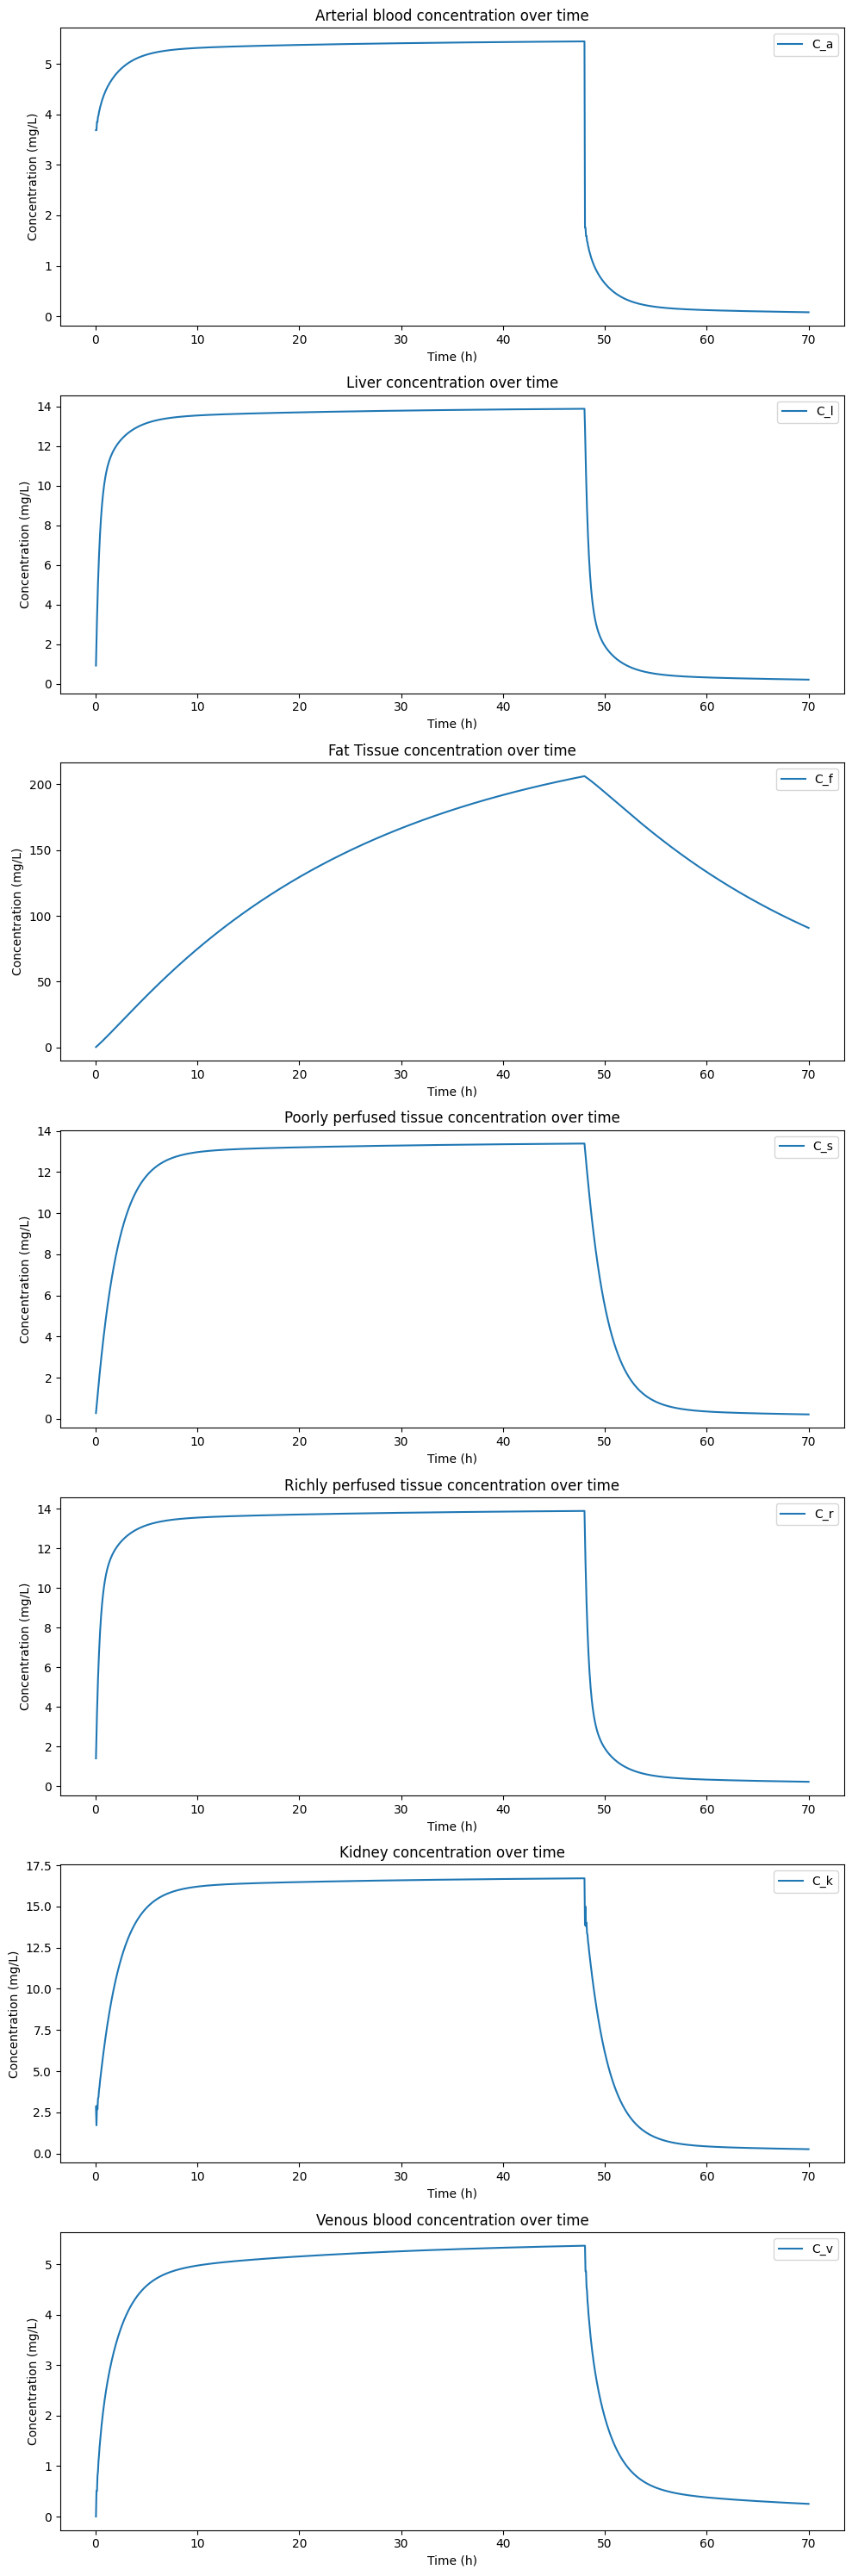

In [99]:

if __name__ == '__main__':
    # Instantiate the model
    model = TroutePBTKModel()
    
    # Run the model
    model.calculate_concentrations()
    
    # Plot the results
    model.plot_results()
    
    # Save the results
    model.save_plots('results.png')
    